# Explaining Neural Network Decisions on Data that have High-level Attributes

CEM_MAFImageExplainer from [AIX360](https://github.com/IBM/AIX360) can be used to obtain contrastive explanations on data that have pre-defined high-level attributes, such as facial images that are annotated with features such as smile, high cheekbones, makeup, etc.

The goal of this tutorial is to demonstrate the use of CEM_MAFImageExplainer, which offers two-part explanations based on a pertinent positive and a pertinent negative. The pertinent positive explanation outputs the minimal set of high-level features that must be present in order for the classification of a sample to remain the same, so that if any one of the output features was missing from the sample, the classification would be different.  The pertinent negative explanation outputs a set of features that would cause a change to the classification if they were added to the sample.

#### Import statements

In [3]:
import tensorflow as tf
import sys
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from zipfile import ZipFile

from aix360.algorithms.contrastive import CEM_MAFImageExplainer
from aix360.algorithms.contrastive import CELEBAModel
from aix360.algorithms.contrastive import KerasClassifier
from aix360.algorithms.contrastive.dwnld_CEM_MAF_celebA import dwnld_CEM_MAF_celebA
from aix360.datasets.celeba_dataset import CelebADataset

dwnld = dwnld_CEM_MAF_celebA()

#### The following steps must be taken to get open-source code:
1. The github project 'progressive_growing_of_gans' must be downloaded from https://github.com/tkarras/progressive_growing_of_gans and placed in the aix360/algorithms/contrastive folder. The project is based on the paper "Progressive Growing of GANs for Improved Quality, Stability, and Variation", ICLR 2018, by Tero Karras, Timo Aila, Samuli Laine, and Jaakko Lehtinen.
2. Another file, karras2018iclr-celebahq-1024x1024.pkl, must be downloaded from https://drive.google.com/drive/folders/15hvzxt_XxuokSmj0uO4xxMTMWVc0cIMU and placed in the progressive_growing_of_gans folder previously downloaded. 
3. The folder 'progressive_growing_of_gans' must be appended to PYTHONPATH.

#### A Tensorflow session is required to run this example

In [2]:
sess = tf.InteractiveSession()
random.seed(120)
np.random.seed(1210)
sess.run(tf.global_variables_initializer())


#### Load CelebA model to be explained. Model must first be downloaded.

In [3]:
# Download pretrained celebA model
local_path_models = '../../aix360/models/CEM_MAF'
celebA_model_file = dwnld.dwnld_celebA_model(local_path_models)

celebA model file downloaded:
['../../aix360/models/CEM_MAF/celebA']


In [4]:
# Load the downloaded celebA model
model_file = '../../aix360/models/CEM_MAF/celebA'
loaded_model = CELEBAModel(restore=model_file, use_softmax=False).model

Load: ../../aix360/models/CEM_MAF/celebA


#### Wrap the CelebA model into a framework independent class structure


In [5]:
mymodel = KerasClassifier(loaded_model)

#### Download a sample image. Note: img_id must be from the following list: [2, 3, 4, 9, 11, 13, 15, 16, 18, 20]. These images are stored publicly and are downloaded here using the function dwnld.dwnld_celebA_data.  The second argument is a list of the image ids to be downloaded.¶

In [6]:
img_id = 15
local_path_img =  '../../aix360/data/celeba_data'
img_files = dwnld.dwnld_celebA_data(local_path_img, [img_id])

Image files downloaded:
['../../aix360/data/celeba_data/15_img.npy', '../../aix360/data/celeba_data/15img.png', '../../aix360/data/celeba_data/15_latent.npy']


 #### Load the image and its latent representations, both to be used to generate a pertinent negative for the sample image. Then process the image and plot.

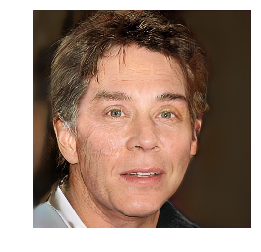

In [7]:
dataset_obj = CelebADataset(local_path_img) # use the CelebA dataset class
input_img = dataset_obj.get_img(img_id)
input_latent = dataset_obj.get_latent(img_id)

# images are processed according to needs for model being explained
input_img = np.clip(input_img/2, -0.5, 0.5)

plt.axis("off")
plt.imshow(input_img[0,:,:,:]+0.5)
plt.show()

#### Predict sample image using 8-class classifier based on 3 binary attributes: young (0 for old,  1 for young), smiling (0 for not smiling), 1 for smiling, and sex (0 for female, 1 for male).

In [8]:
orig_prob, orig_class, orig_prob_str = mymodel.predict_long(input_img)
# Compute classes
young_flag = orig_class % 2
smile_flag = (orig_class // 2) % 2
sex_flag = (orig_class // 4) % 2

arg_img_name = os.path.join(local_path_img, "{}_img.png".format(img_id))
print("Image:{}, pred:{}".format(arg_img_name, orig_class))
print("Male:{}, Smile:{}, Young:{}".format(sex_flag, smile_flag, young_flag))
orig_img = input_img
target_label = [np.eye(mymodel._nb_classes)[orig_class]]

Image:../../aix360/data/celeba_data/15_img.png, pred:4
Male:1, Smile:0, Young:0


#### Downloaded pretrained attribute classifiers to use for explaining the loaded model. Each attribute in the following list has a binary classifier to be taken as input to CEM_MAF.

In [9]:
attributes = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Gray_Hair", "Wearing_Lipstick", "Heavy_Makeup",\
                "High_Cheekbones", "Bangs", "Oval_Face", "Narrow_Eyes", "Bags_Under_Eyes", "Pointy_Nose"]
# Download attribute functions
attr_model_files = dwnld.dwnld_celebA_attributes(local_path_models, attributes)

Attribute files downloaded:
['../../aix360/models/CEM_MAF/simple_Black_Hair_model.json', '../../aix360/models/CEM_MAF/simple_Black_Hair_weights.h5', '../../aix360/models/CEM_MAF/simple_Black_Hair.ckpt', '../../aix360/models/CEM_MAF/simple_Blond_Hair.ckpt', '../../aix360/models/CEM_MAF/simple_Blond_Hair_weights.h5', '../../aix360/models/CEM_MAF/simple_Blond_Hair_model.json', '../../aix360/models/CEM_MAF/simple_Brown_Hair_weights.h5', '../../aix360/models/CEM_MAF/simple_Brown_Hair_model.json', '../../aix360/models/CEM_MAF/simple_Brown_Hair.ckpt', '../../aix360/models/CEM_MAF/simple_Gray_Hair.ckpt', '../../aix360/models/CEM_MAF/simple_Gray_Hair_weights.h5', '../../aix360/models/CEM_MAF/simple_Gray_Hair_model.json', '../../aix360/models/CEM_MAF/simple_Wearing_Lipstick_model.json', '../../aix360/models/CEM_MAF/simple_Wearing_Lipstick_weights.h5', '../../aix360/models/CEM_MAF/simple_Wearing_Lipstick.ckpt', '../../aix360/models/CEM_MAF/simple_Heavy_Makeup.ckpt', '../../aix360/models/CEM_MAF/s

#### Set up a CEM_MAF explainer object with respect to the trained CelebA model and high-level attributes.


In [10]:
aix360_path = '../../aix360' # needed to find paths to attribute files
explainer = CEM_MAFImageExplainer(mymodel, attributes, aix360_path)

#### Obtain the pertinent negative explaination

In [11]:
# parameter values for the pertinent negative
arg_mode = 'PN'
arg_kappa = 5
arg_gamma = 1
arg_binary_search_steps = 1
arg_max_iterations = 250
arg_initial_const = 10
arg_attr_reg = 100.0
arg_attr_penalty_reg = 100.0
arg_latent_square_loss_reg = 1.0

In [12]:
(adv_pn, attr_pn, info_pn) = explainer.explain_instance(sess, input_img, 
                    input_latent, arg_mode, arg_kappa, arg_binary_search_steps, 
                    arg_max_iterations, arg_initial_const, arg_gamma, None, 
                    arg_attr_reg, arg_attr_penalty_reg, 
                    arg_latent_square_loss_reg)
    
print(info_pn)

Loaded model for Black_Hair from disk
Loaded model for Blond_Hair from disk
Loaded model for Brown_Hair from disk
Loaded model for Gray_Hair from disk
Loaded model for Wearing_Lipstick from disk
Loaded model for Heavy_Makeup from disk
Loaded model for High_Cheekbones from disk
Loaded model for Bangs from disk
Loaded model for Oval_Face from disk
Loaded model for Narrow_Eyes from disk
Loaded model for Bags_Under_Eyes from disk
Loaded model for Pointy_Nose from disk
# of attr models is 12
iter:0 const:[10.]
Loss_Overall:7385.9272, Loss_Attack:0.0000, Loss_attr:1.2358
Loss_Latent_L2Dist:20.1870, Loss_Img_L2Dist:7021.6318
target_lab_score:-2.7435, max_nontarget_lab_score:5.0185

iter:10 const:[10.]
Loss_Overall:5924.4990, Loss_Attack:0.0000, Loss_attr:0.8909
Loss_Latent_L2Dist:1159.0074, Loss_Img_L2Dist:4563.6479
target_lab_score:0.6903, max_nontarget_lab_score:6.1033

iter:20 const:[10.]
Loss_Overall:3637.8708, Loss_Attack:0.0000, Loss_attr:0.5807
Loss_Latent_L2Dist:789.6542, Loss_Img_L2D

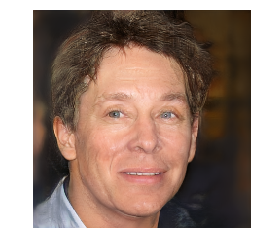

Pertinent Negative pred:6
Male:1, Smile:1, Young:0
Added High_Cheekbones


In [13]:
plt.axis("off")
plt.imshow(adv_pn[0,:,:,:]+0.5)
plt.show()
    
# Compute new classes
adv_prob, adv_class, adv_prob_str = mymodel.predict_long(adv_pn)
young_flag = adv_class % 2
smile_flag = (adv_class // 2) % 2
sex_flag = (adv_class // 4) % 2
print("Pertinent Negative pred:{}".format(adv_class))
print("Male:{}, Smile:{}, Young:{}".format(sex_flag, smile_flag, young_flag))
print(attr_pn)

#### Obtain the pertinent positive explaination

In [14]:
# Parameter values for the pertinent positive 
# Note that regularization parameters need for pertinent negative are not need here
arg_mode = 'PP'
arg_kappa = 5
arg_gamma = 100.0
arg_beta = 0.1
arg_binary_search_steps = 1
arg_max_iterations = 100
arg_initial_const = 10
    
(adv_pp, __, __) = explainer.explain_instance(sess, input_img, None, arg_mode, arg_kappa, 
                    arg_binary_search_steps, arg_max_iterations, 
                    arg_initial_const, arg_gamma, arg_beta)

Creating a mask for pertinent positive
Loaded model for Black_Hair from disk
Loaded model for Blond_Hair from disk
Loaded model for Brown_Hair from disk
Loaded model for Gray_Hair from disk
Loaded model for Wearing_Lipstick from disk
Loaded model for Heavy_Makeup from disk
Loaded model for High_Cheekbones from disk
Loaded model for Bangs from disk
Loaded model for Oval_Face from disk
Loaded model for Narrow_Eyes from disk
Loaded model for Bags_Under_Eyes from disk
Loaded model for Pointy_Nose from disk
# of attr models is 12
iter:0 const:[10.]
Loss_Overall:4382.9561, Loss_Attack:0.0000, Loss_attr:0.0771
Loss_L2Dist:39100.1719, Loss_L1Dist:43718.0234, AE_loss:0.0
target_lab_score:4.3499, max_nontarget_lab_score:-7.6034

iter:10 const:[10.]
Loss_Overall:436.1061, Loss_Attack:47.2062, Loss_attr:0.3453
Loss_L2Dist:2466.2612, Loss_L1Dist:3463.2842, AE_loss:0.0
target_lab_score:-2.1829, max_nontarget_lab_score:-2.4623

iter:20 const:[10.]
Loss_Overall:698.1842, Loss_Attack:0.0000, Loss_attr:

#### Display the result and check the class

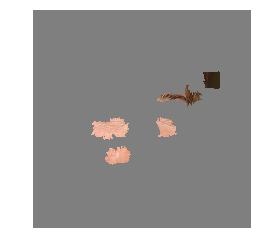

Pertinent positive pred:4
Male:1, Smile:0, Young:0


In [15]:
plt.axis("off")
plt.imshow(adv_pp[0,:,:,:]+0.5)
plt.show()
    
# Compute class of PP
adv_prob, adv_class, adv_prob_str = mymodel.predict_long(adv_pp)
young_flag = adv_class % 2
smile_flag = (adv_class // 2) % 2
sex_flag = (adv_class // 4) % 2
print("Pertinent positive pred:{}".format(adv_class))
print("Male:{}, Smile:{}, Young:{}".format(sex_flag, smile_flag, young_flag))